In [14]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [15]:
emotion_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
df=pd.read_csv('/kaggle/input/facial-expression/fer2013.csv')

In [16]:
df.head(10)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


In [17]:
m,n = df.shape
print(m,n)

35887 3


In [18]:
# Process data from FER2013
def preprocess_data(data):
    labels = data['emotion'].values
    
    # Takes string values and forms an array with float32 data points of size 48 by 48
    images = data['pixels'].apply(lambda x: np.array(x.split(), dtype='float32').reshape(48, 48))
    
    # Stack images into a 3D array (num_samples, 48, 48) -> (35887, 48, 48)
    images = np.stack(images.values)  
    
    # Add a channel dimension for grayscale -> (num_samples, channels, 48, 48) -> (35887, 1, 48, 48)
    # Pytorch models expect in format of (batch_size, channels, height, width)
    images = np.expand_dims(images, axis=1)  
    
    # Normalize pixel values to [0, 1]
    images /= 255.0  
    return images, labels

# Split data into train and test datasets
train_images, train_labels = preprocess_data(df[:30000])
test_images, test_labels = preprocess_data(df[30000:])

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

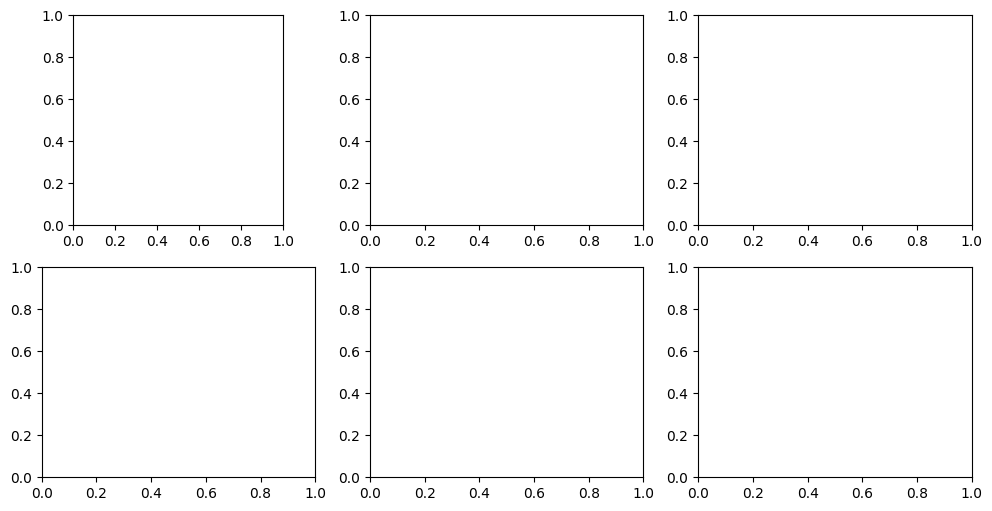

In [19]:

# # Number of images to display
# num_images = 5
# # Define the number of columns for the grid layout
# num_cols = 3
# # Calculate the number of rows needed
# num_rows = (num_images + num_cols - 1) // num_cols  # Ceiling division

# # Create a figure with subplots
# fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 3))

# # Flatten the axes array for easier iteration
# axes = axes.flatten()

# for i in range(num_images):
#     ex_emotion = emotion_map[labels[i]]  # Provides format of (1,48,48)
#     ex_image = images[i].squeeze()  # Squeezes first dimension to become (48,48)

#     # Displaying with pyplot from matplotlib (do not need to convert back into 0-255, can keep as 0-1)
#     axes[i].imshow(ex_image, cmap='gray')
#     axes[i].set_title(f'Emotion Label: {ex_emotion}')
#     axes[i].axis('off')

# # Turn off the axes for unused plots
# for j in range(num_images, len(axes)):
#     axes[j].axis('off')

# plt.show()

In [20]:
# Define Dataset
class FER2013Dataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.tensor(images, dtype=torch.float32)  # Convert numpy array to torch tensor
        self.labels = torch.tensor(labels, dtype=torch.long)    # Convert labels to long tensor for classification

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label
    
batch_size = 64
shuffle = True

# Create dataset instance
train_dataset = FER2013Dataset(train_images, train_labels)
test_dataset = FER2013Dataset(test_images, test_labels)

# Create data loader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

In [21]:
# Define the model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 7)  # 7 emotions

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN().to(device)

In [22]:
num_epochs = 10
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images,labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)  # Move data to GPU

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{i + 1}/{len(dataloader)}], Loss: {running_loss / (i + 1):.4f}')
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader):.4f}')

# Save the model
torch.save(model.state_dict(), 'fer2013_model.pth')

Epoch [1/10], Batch [100/561], Loss: 1.7890
Epoch [1/10], Batch [200/561], Loss: 1.7415
Epoch [1/10], Batch [300/561], Loss: 1.7064
Epoch [1/10], Batch [400/561], Loss: 1.6762
Epoch [1/10], Batch [500/561], Loss: 1.6527
Epoch [1/10], Loss: 1.6387
Epoch [2/10], Batch [100/561], Loss: 1.4895
Epoch [2/10], Batch [200/561], Loss: 1.4720
Epoch [2/10], Batch [300/561], Loss: 1.4616
Epoch [2/10], Batch [400/561], Loss: 1.4511
Epoch [2/10], Batch [500/561], Loss: 1.4392
Epoch [2/10], Loss: 1.4332
Epoch [3/10], Batch [100/561], Loss: 1.3298
Epoch [3/10], Batch [200/561], Loss: 1.3320
Epoch [3/10], Batch [300/561], Loss: 1.3263
Epoch [3/10], Batch [400/561], Loss: 1.3241
Epoch [3/10], Batch [500/561], Loss: 1.3151
Epoch [3/10], Loss: 1.3148
Epoch [4/10], Batch [100/561], Loss: 1.2245
Epoch [4/10], Batch [200/561], Loss: 1.2242
Epoch [4/10], Batch [300/561], Loss: 1.2290
Epoch [4/10], Batch [400/561], Loss: 1.2344
Epoch [4/10], Batch [500/561], Loss: 1.2285
Epoch [4/10], Loss: 1.2268
Epoch [5/10]

In [23]:
from sklearn.metrics import classification_report, accuracy_score

# Assuming you have a DataLoader for the test set
model.eval()  # Set the model to evaluation mode
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy:.4f}')

print(classification_report(all_labels, all_preds))

Accuracy: 0.7551
              precision    recall  f1-score   support

           0       0.76      0.66      0.71       780
           1       0.85      0.87      0.86        90
           2       0.64      0.67      0.65       828
           3       0.84      0.91      0.88      1468
           4       0.65      0.66      0.66      1028
           5       0.87      0.88      0.87       673
           6       0.74      0.67      0.70      1020

    accuracy                           0.76      5887
   macro avg       0.76      0.76      0.76      5887
weighted avg       0.75      0.76      0.75      5887



In [25]:
torch.save(model.state_dict(), 'fer2013_model.pth')